In [ ]:
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import archimedes as arc
from archimedes.experimental.discretize import discretize_rk4
from archimedes.experimental import lqr_design

from cartpole import CartPole

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Dynamics function
system = CartPole()

# Discretize the dynamics
dt = 0.01
# f = discretize_rk4(system.dynamics, dt)

x0 = np.array([0.0, np.pi + 1e-2, 0.0, 0.0])  # Initial state
xf = np.array([1.0, np.pi, 0.0, 0.0])  # Target state

t0, tf = 0.0, 2.0

u0 = np.array([0.0])
ts = np.arange(t0, tf, dt)


def f(t, x):
    return system.dynamics(t, x, u0)


xs = arc.odeint(f, x0=x0, t_span=(t0, tf), t_eval=ts, rtol=1e-6, atol=1e-8)
us = np.zeros((len(ts), 1))
# xs = np.zeros((len(ts), 4))
# xs[0] = x0
# for i in range(1, len(ts)):
#     xs[i] = f(ts[i-1], xs[i-1], us[i])

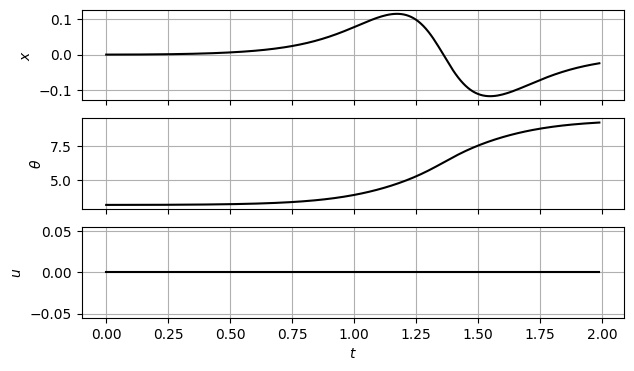

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].plot(ts, xs[0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs[1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].plot(ts, us, c="k")
ax[2].grid()
ax[2].set_ylabel(r"$u$")
ax[2].set_xlabel(r"$t$")

plt.show()

# Linearize about target point

In [17]:
A = arc.jac(system.dynamics, argnums=1)(t0, xf, u0)
B = arc.jac(system.dynamics, argnums=2)(t0, xf, u0)

# Finite horizon LQR

In [18]:
nx, nu = 4, 1
Qf = 100 * np.diag(np.ones(nx))
Q = np.diag(np.ones(nx))
R = 1e-2 * np.diag(np.ones(nu))
R_inv = np.linalg.inv(R)

Qf, Q, R

(array([[100.,   0.,   0.,   0.],
        [  0., 100.,   0.,   0.],
        [  0.,   0., 100.,   0.],
        [  0.,   0.,   0., 100.]]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[0.01]]))

In [19]:
# Differential Riccatti equation (square root form)
# Integrate Riccati equation from t = tf to t = 0
# Transform time variable to tau = -t and
# integrate from tau = -t0 to tau = -t0
# In this case we just change the sign of S_t (usually has a negative sign
# when integrating backwards in time)
def riccati_rhs(t, x):
    t = -t
    P = np.reshape(x, (nx, nx))
    S = P @ P.T
    P_t = A.T @ P - 0.5 * S @ (B @ R_inv @ B.T) @ P + 0.5 * Q * np.linalg.inv(P)
    return P_t.flatten()


P0 = np.linalg.cholesky(Qf)
P = arc.odeint(
    riccati_rhs, x0=P0.flatten(), t_span=(-tf, -t0), t_eval=ts, rtol=1e-9, atol=1e-12
)
P = np.reshape(P.T, (len(ts), nx, nx))
S = np.array([P[i] @ P[i].T for i in range(len(ts))])

In [20]:
Ks = np.zeros((len(ts), nu, nx))
for i in range(len(ts)):
    Ks[i] = R_inv @ B.T @ S[i]


def K(t):
    # Linear interpolation for each element of K (inefficient?)
    _K = [np.interp(t, ts, Ks[:, i, j]) for i in range(nu) for j in range(nx)]
    return np.stack(_K).reshape((nu, nx))


def u(t, x):
    return -K(t) @ x


@arc.compile
def lqr_rhs(t, x):
    return A @ x + B @ u(t, x)


xs = arc.odeint(lqr_rhs, t_span=(t0, tf), x0=(x0 - xf), t_eval=ts)
us = np.array([u(t, x) for t, x in zip(ts, xs.T)])
xs += xf[:, None]  # Shift back to original position

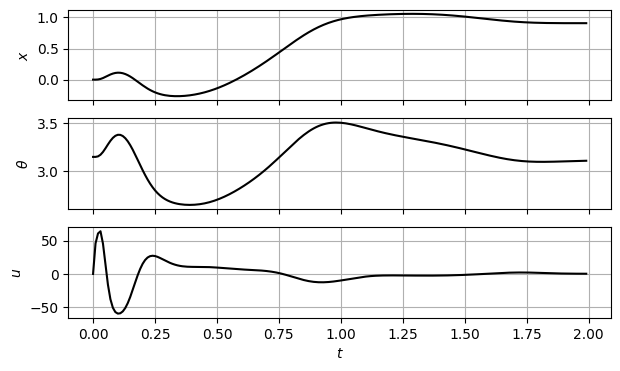

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].plot(ts, xs[0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs[1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].plot(ts, us, c="k")
ax[2].grid()
ax[2].set_ylabel(r"$u$")
ax[2].set_xlabel(r"$t$")

plt.show()

### Use built-in function

In [ ]:
nx, nu = 4, 1
Qf = 100 * np.diag(np.ones(nx))
Q = np.diag(np.ones(nx))
R = 1e-2 * np.diag(np.ones(nu))

In [49]:
u_lqr = lqr_design(
    system.dynamics,
    x0=lambda t: xf,
    u0=lambda t: u0,
    ts=ts,
    Qf=Qf,
    Q=Q,
    R=R,
)


@arc.compile
def lqr_rhs(t, x):
    u = u0 + u_lqr(t, x)
    return system.dynamics(t, x, u)


xs = arc.odeint(lqr_rhs, t_span=(t0, tf), x0=x0, t_eval=ts)
# us = arc.vmap(u, in_axes=(0, 0))(ts, xs.T)
us = np.array([u(t, x) for t, x in zip(ts, xs.T)])

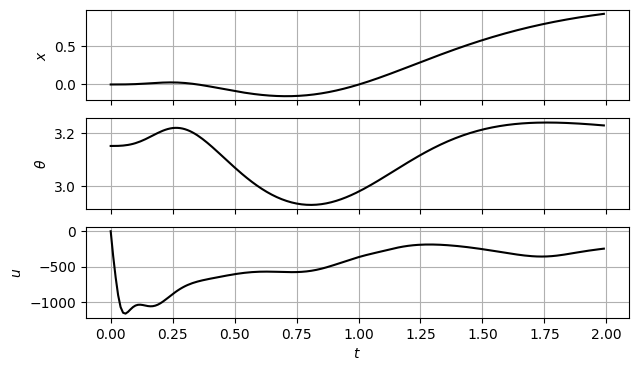

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(7, 4), sharex=True)
ax[0].plot(ts, xs[0], c="k")
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].plot(ts, xs[1], c="k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].plot(ts, us, c="k")
ax[2].grid()
ax[2].set_ylabel(r"$u$")
ax[2].set_xlabel(r"$t$")

plt.show()